# Урок 2.

Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

#### Библиотеки, которые нужно установить:

gensim razdel pymorphy2 nltk

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import pandas as pd
import re
import numpy as np

#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

from nltk.corpus import stopwords 
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
import pymorphy2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

news = pd.read_csv("materials.csv") # заголовки статей
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [2]:
users = pd.read_csv("users_articles.csv") # Загрузим пользователей и списки последних прочитанных новостей
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### векторные представления новостей

In [3]:
# скачаем стоп слова
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# добавим стоп слова на русском языке (а то в стандартной сборке их мало)
stopword_ru = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

print(f'Всего стоп слов: {len(stopword_ru) }')

Всего стоп слов: 776


In [5]:
def clean_text(text):
    '''Очищает текст от символов, цифр и знаков препинания.
    Возвращает очищенный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    return text


cache = {} # кешируем те слова, которые уже обработали через лемматизацию

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [6]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/tmp/ipykernel_6400/687518757.py:12: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 32.6 s, sys: 216 ms, total: 32.8 s
Wall time: 32.9 s


In [7]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 15s, sys: 553 ms, total: 3min 15s
Wall time: 3min 16s


In [8]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

common_dictionary[10]

'ватутин'

Запускаем обучение

In [9]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 48.3 s, sys: 51.4 s, total: 1min 39s
Wall time: 42.8 s


In [10]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [11]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.23237357),
 (3, 0.32088274),
 (14, 0.079572305),
 (15, 0.28862604),
 (21, 0.057266638)]

In [12]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: писать авария страдать nn предполагаться пострадать выдать
topic_1: способность письмо соцсеть теория дыра немедленно выручка
topic_2: мужчина женщина взрыв активность доклад произойти место
topic_3: фестиваль nn конструкция мероприятие употребление состояться сайт
topic_4: рак кость автономный тереза воспаление трансляция кузнецов
topic_5: исследование научный риск nn экономика глава пациент
topic_6: украина nn станция украинский республика территория правительство
topic_7: ребёнок гражданин выяснить россиянин автор журнал обнаружить
topic_8: сша газ россия снижение сторона американский российский
topic_9: население журнал век налог восток норма превысить
topic_10: тело лаборатория расследование дом вероятно умереть вуз
topic_11: область район пострадать офицер управление оборудование лечение
topic_12: поверхность квартира обнаружить энергия отряд океан изучение
topic_13: москва статья сотрудник всё власть решение nn
topic_14: цена американский новый сша млн тыс предполагать


Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [13]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [14]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.013478,0.0,0.000000,0.106279,0.0,0.0,0.012349,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.071910,0.317362,0.0
1,4896,0.000000,0.0,0.408117,0.395966,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.172716,0.000000,0.0
2,4897,0.232236,0.0,0.000000,0.320879,0.0,0.0,0.000000,0.0,0.0,...,0.288647,0.0,0.0,0.0,0.0,0.0,0.057257,0.000000,0.000000,0.0
3,4898,0.000000,0.0,0.000000,0.086971,0.0,0.0,0.000000,0.0,0.0,...,0.772296,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.129668,0.0
4,4899,0.000000,0.0,0.000000,0.191635,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.781286,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [15]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [16]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

doc_dict[293622]

array([0.10177305, 0.        , 0.04377203, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.11294179, 0.09739922,
       0.        , 0.        , 0.        , 0.        , 0.06001052,
       0.1926259 , 0.        , 0.        , 0.        , 0.18467069,
       0.        , 0.        , 0.        , 0.15912651, 0.03681955])

In [17]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, method='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if method == 'mean':
        user_vector = np.mean(user_vector, 0)
    if method == 'median':
        user_vector = np.median(user_vector, 0)
    if method == 'max':
        user_vector = np.max(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list, method='mean')

array([0.01112655, 0.        , 0.        , 0.        , 0.02604264,
       0.0711442 , 0.0038632 , 0.08716605, 0.06797634, 0.01959101,
       0.00536483, 0.02203882, 0.00426822, 0.19486325, 0.01427434,
       0.02663299, 0.00912112, 0.00557913, 0.        , 0.00639233,
       0.01031938, 0.0123796 , 0.16475652, 0.21875347, 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [18]:
#users['articles'].iloc[33]

In [19]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [20]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, method='mean'), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.046314,0.000000,0.016479,0.026151,0.000000,0.066520,0.077348,0.070782,0.049310,...,0.061303,0.000000,0.007975,0.0,0.054682,0.026929,0.049753,0.062590,0.065694,0.006137
1,u108690,0.012772,0.004207,0.028793,0.002712,0.000000,0.070627,0.055077,0.059097,0.089701,...,0.101261,0.002284,0.018265,0.0,0.044239,0.017063,0.000000,0.087171,0.080572,0.001742
2,u108339,0.008964,0.001729,0.016865,0.002234,0.011818,0.021416,0.050272,0.043742,0.046044,...,0.034590,0.008648,0.050638,0.0,0.044170,0.020420,0.000000,0.111432,0.070418,0.000000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [21]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [22]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.046314,0.000000,0.016479,0.026151,0.000000,0.066520,0.077348,0.070782,0.049310,...,0.000000,0.007975,0.0,0.054682,0.026929,0.049753,0.062590,0.065694,0.006137,0
1,u108690,0.012772,0.004207,0.028793,0.002712,0.000000,0.070627,0.055077,0.059097,0.089701,...,0.002284,0.018265,0.0,0.044239,0.017063,0.000000,0.087171,0.080572,0.001742,1
2,u108339,0.008964,0.001729,0.016865,0.002234,0.011818,0.021416,0.050272,0.043742,0.046044,...,0.008648,0.050638,0.0,0.044170,0.020420,0.000000,0.111432,0.070418,0.000000,1


In [23]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.19944853, 0.04917525, 0.18601848, 0.2533088 , 0.1346467 ,
       0.14343535, 0.10211846, 0.05877471, 0.01875327, 0.10184801])

### Рассчитаем Precision, Recall, F_score

In [24]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.250526, F-Score=0.721, Precision=0.636, Recall=0.833


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1638  117]
 [  42  203]]


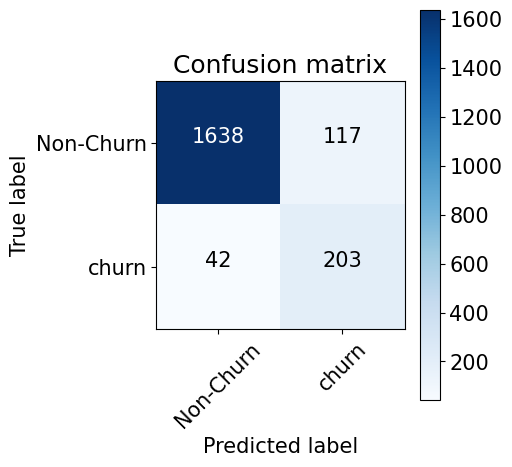

In [26]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.show()

In [27]:
roc_auc_score(y_test, preds)

0.9565416593988021

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

## Метод: среднее, медиана, максимум

In [38]:
def make_model_predict(method):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, method=method), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

    target = pd.read_csv("users_churn.csv")
    X = pd.merge(user_embeddings, target, 'left')

    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                        X['churn'], random_state=0)

    logreg = LogisticRegression()
    #обучим 
    logreg.fit(X_train, y_train)

    #наши прогнозы для тестовой выборки
    preds = logreg.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    return method, thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)

In [41]:
pd.DataFrame([
    make_model_predict(method='mean'),
    make_model_predict(method='median'),
    make_model_predict(method='max')
],
columns=['method', 'BestThreshold', 'FScore', 'Precision', 'Recall', 'roc_auc_score'])

,method,BestThreshold,FScore,Precision,Recall,roc_auc_score
0,mean,0.250526,0.720848,0.635514,0.832653,0.956542
1,median,0.289507,0.777143,0.728571,0.832653,0.974917
2,max,0.431996,0.842105,0.869565,0.816327,0.985194
